In [1]:
import numpy as np
import pandas as pd
from prophet import Prophet
import os
# import itertools
# from prophet.diagnostics import cross_validation, performance_metrics
# from dask.distributed import Client


import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_season(date):
    month = date.month
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

In [3]:
months = ['jan', 'feb', 'mar','apr', 'may','jun','jul', 'aug', 'sep','oct','nov','dec']
days = ['mon','tue','wed','thu','fri','sat', 'sun']

seasons = ["summer", "winter", "spring", "fall"]
day_types = ['weekday', 'weekend']

temp_types = ['cold', 'warm']
humid_types = ['humid', 'notHumid']

parkade = 'North'

In [4]:
# Get the paths to the data files
current_directory = os.getcwd()
csv_folder = os.path.join(current_directory, '..', 'data')
train_data_file_path = os.path.join(csv_folder, 'data_train_newCovid.csv')
test_data_file_path = os.path.join(csv_folder, 'data_test_newCovid.csv')


In [5]:
# Save the train and test data as dataframes
test_data = pd.read_csv(test_data_file_path,parse_dates=[0], index_col=[0], usecols=['Timestamp', parkade, 'temp', 'humidity'])
train_data = pd.read_csv(train_data_file_path,parse_dates=[0], index_col=[0], usecols=['Timestamp', parkade, 'temp', 'humidity'])
train_data.head()
parks = ["North","West","Rose","Health Sciences","Fraser","Thunderbird","University Lot Blvd"]
capacities = {
    "North" : 1010,
    "West" : 1219,
    "Rose" : 800,
    "Health Sciences" : 1022,
    "Fraser" : 725,
    "Thunderbird" : 1634,
    "University Lot Blvd" : 216
}

In [6]:
train_data.head()


North   temp  humidity
Timestamp                                  
2018-09-06 10:00:00    951  14.59        75
2018-09-06 11:00:00    922  14.01        76
2018-09-06 12:00:00    833  14.16        79
2018-09-06 13:00:00    851  13.85        76
2018-09-06 14:00:00    857  13.96        74

In [7]:
train_data

North   temp  humidity
Timestamp                                  
2018-09-06 10:00:00    951  14.59        75
2018-09-06 11:00:00    922  14.01        76
2018-09-06 12:00:00    833  14.16        79
2018-09-06 13:00:00    851  13.85        76
2018-09-06 14:00:00    857  13.96        74
...                    ...    ...       ...
2023-03-05 03:00:00      9   4.64        81
2023-03-05 04:00:00     10   4.84        78
2023-03-05 05:00:00     10   4.96        76
2023-03-05 06:00:00     11   4.66        78
2023-03-05 07:00:00     12   4.71        77

[26399 rows x 3 columns]

In [8]:

train_prophet = train_data.reset_index() \
.rename(columns={'Timestamp':'ds',
                    parkade:'y'})

test_prophet = test_data.reset_index() \
.rename(columns={'Timestamp':'ds',
                    parkade:'y'})



In [9]:
# day_of_week == 0 => Monday
# day_of_week == 1 => Tuesday
# day_of_week == 2 => Wednesday
# day_of_week == 3 => Thursday
# day_of_week == 4 => Friday
# day_of_week == 5 => Saturday
# day_of_week == 6 => Sunday

def is_weekend(ds):
    date = pd.to_datetime(ds)
    return (date.day_of_week == 6 or date.day_of_week == 5)


#--------------------------------------------------------------------

def is_summer(ds):
    date = pd.to_datetime(ds)
    return (date.month == 6 or date.month == 7 or date.month == 8)

def is_winter(ds):
    date = pd.to_datetime(ds)
    return (date.month == 12 or date.month == 1 or date.month == 2 )

def is_fall(ds):
    date = pd.to_datetime(ds)
    return (date.month == 9 or date.month == 10 or date.month == 11)

def is_spring(ds):
    date = pd.to_datetime(ds)
    return (date.month == 3 or date.month == 4 or date.month == 5)
#--------------------------------------------------------------------


term_dates_df = pd.read_csv('../data/term dates.csv', parse_dates=[0])
def is_vacation(ds):
    # i = 0
    date = pd.to_datetime(ds)
    for i in range(0,len(term_dates_df)-2,2):
        if(date > term_dates_df.loc[i]['Timestamp'] and date < term_dates_df.loc[i+1]['Timestamp']):
            return False
    return True


def set_month(ds, m):
    date = pd.to_datetime(ds)
    return (date.month == m)


def set_day(ds, d):
    date = pd.to_datetime(ds)
    return (date.day_of_week == d)

def is_cold(temp):
    return (temp < 10)

def is_humid(humidity):
    return (humidity > 50)



In [10]:

train_prophet['weekend'] = train_prophet['ds'].apply(is_weekend)
train_prophet['weekday'] = ~train_prophet['ds'].apply(is_weekend)
    
train_prophet['summer'] = train_prophet['ds'].apply(is_summer)
train_prophet['winter'] = train_prophet['ds'].apply(is_winter)
train_prophet['fall'] = train_prophet['ds'].apply(is_fall)
train_prophet['spring'] = train_prophet['ds'].apply(is_spring)

# train_prophet[['summer', 'spring', 'fall', 'winter']] = train_prophet['ds'].apply(set_season)

train_prophet['vacation'] = train_prophet['ds'].apply(is_vacation)
train_prophet['school_term'] = ~train_prophet['ds'].apply(is_vacation)

train_prophet['vacation_AND_weekend'] = train_prophet['vacation'] & train_prophet['weekend'] 
train_prophet['vacation_AND_weekday'] = train_prophet['vacation'] & ~train_prophet['weekend'] 
train_prophet['school_term_AND_weekend'] = ~train_prophet['vacation'] & train_prophet['weekend'] 
train_prophet['school_term_AND_weekday'] = ~train_prophet['vacation'] & ~train_prophet['weekend'] 


train_prophet['cold'] = train_prophet['temp'].apply(is_cold)
train_prophet['warm'] = ~train_prophet['temp'].apply(is_cold)

train_prophet['humid'] = train_prophet['humidity'].apply(is_humid)
train_prophet['notHumid'] = ~train_prophet['humidity'].apply(is_humid)



for i in range(len(months)):
    train_prophet[months[i]] = train_prophet['ds'].apply(set_month, m=i+1)


for i in range(len(days)):
    train_prophet[days[i]] = train_prophet['ds'].apply(set_day, d=i)


#Conditions

for season in seasons:
    for day_type in day_types:
        train_prophet[f'{season}_AND_{day_type}'] = train_prophet[season] & train_prophet[day_type] 

for season in seasons:
    for day in days:
        train_prophet[f'{season}_AND_{day}'] = train_prophet[season] & train_prophet[day]


for month in months:
    for day in days:
        train_prophet[f'{month}_AND_{day}'] = train_prophet[month] & train_prophet[day]

for month in months:
    for day_type in day_types:
        train_prophet[f'{month}_AND_{day_type}'] = train_prophet[month] & train_prophet[day_type] 

for month in months:
    for day_type in day_types:
        for temp in temp_types:
            for humid in humid_types:
                train_prophet[f'{month}_AND_{day_type}_AND_{temp}_AND_{humid}'] = train_prophet[month] & train_prophet[day_type] \
                & train_prophet[temp] & train_prophet[humid]


In [11]:
# train_prophet.to_csv("../test_df/train_weekend.csv")

In [12]:
test_prophet['weekend'] = test_prophet['ds'].apply(is_weekend)
test_prophet['weekday'] = ~test_prophet['ds'].apply(is_weekend)

    
test_prophet['summer'] = test_prophet['ds'].apply(is_summer)
test_prophet['winter'] = test_prophet['ds'].apply(is_winter)
test_prophet['fall'] = test_prophet['ds'].apply(is_fall)
test_prophet['spring'] = test_prophet['ds'].apply(is_spring)

test_prophet['vacation'] = test_prophet['ds'].apply(is_vacation)
test_prophet['school_term'] = ~test_prophet['ds'].apply(is_vacation)

test_prophet['vacation_AND_weekend'] = test_prophet['vacation'] & test_prophet['weekend'] 
test_prophet['vacation_AND_weekday'] = test_prophet['vacation'] & ~test_prophet['weekend'] 
test_prophet['school_term_AND_weekend'] = ~test_prophet['vacation'] & test_prophet['weekend'] 
test_prophet['school_term_AND_weekday'] = ~test_prophet['vacation'] & ~test_prophet['weekend'] 

test_prophet['cold'] = test_prophet['temp'].apply(is_cold)
test_prophet['warm'] = ~test_prophet['temp'].apply(is_cold)

test_prophet['humid'] = test_prophet['humidity'].apply(is_humid)
test_prophet['notHumid'] = ~test_prophet['humidity'].apply(is_humid)

for i in range(len(months)):
    test_prophet[months[i]] = test_prophet['ds'].apply(set_month, m=i+1)


for i in range(len(days)):
    test_prophet[days[i]] = test_prophet['ds'].apply(set_day, d=i)


# Conditions: 
for season in seasons:
    for day_type in day_types:
        test_prophet[f'{season}_AND_{day_type}'] = test_prophet[season] & test_prophet[day_type] 

for season in seasons:
    for day in days:
        test_prophet[f'{season}_AND_{day}'] = test_prophet[season] & test_prophet[day]

for month in months:
    for day in days:
        test_prophet[f'{month}_AND_{day}'] = test_prophet[month] & test_prophet[day]

for month in months:
    for day_type in day_types:
        test_prophet[f'{month}_AND_{day_type}'] = test_prophet[month] & test_prophet[day_type] 

#---------------------------------------------------------------------------
for month in months:
    for day_type in day_types:
        for temp in temp_types:
            for humid in humid_types:
                test_prophet[f'{month}_AND_{day_type}_AND_{temp}_AND_{humid}'] = test_prophet[month] & test_prophet[day_type] \
                & test_prophet[temp] & test_prophet[humid]



In [20]:
# parks = ["North","West","Rose","Health Sciences","Fraser","Thunderbird","University Lot Blvd"]
# capacities = [1010, 1219, 800, 1022, 725, 1634, 216]

metrics_df = pd.DataFrame(index=pd.Index(['MAE', 'MSE', 'RMSE' ,'R2'], name='metrics'))
metrics_df_abs = pd.DataFrame(index=pd.Index(['MAE_abs', 'MSE_abs', 'RMSE_abs' ,'R2_abs'], name='metrics'))

# Hyperparamters tuned for North Parkade
changepoint_prior_scale = 0.0001
seasonality_prior_scale = 0.265

yearly_seasonality = 10
weekly_seasonality = 22
daily_seasonality = 39

weekly_prior_scale = 0.1
daily_prior_scale = 10.0

# for parkade in parks:

model = Prophet(    changepoint_prior_scale=changepoint_prior_scale,
                    seasonality_prior_scale=seasonality_prior_scale,
                    yearly_seasonality=yearly_seasonality,
                    weekly_seasonality=False,
                    daily_seasonality=False,
                    # seasonality_mode='multiplicative',
                    growth='linear'
                    # growth='logistic'
                                    )

model.add_country_holidays(country_name='Canada')
# model.add_seasonality(name=f'hourly', period=1/24, fourier_order=15,\
#                        prior_scale=0.1)

# model.add_seasonality(name=f'quarterly', period=91.3125, fourier_order=10,\
#                        prior_scale=1.0)


# for month in months:
#     for day_type in day_types:
#         for temp in temp_types:
#             for humid in humid_types:
#                 model.add_seasonality(name=f'daily_{month}_{day_type}_{temp}_{humid}', period=1, fourier_order=daily_seasonality, \
#                                condition_name=f'{month}_AND_{day_type}_AND_{temp}_AND_{humid}', prior_scale=daily_prior_scale)

#-----------------------------------------------------------------------------------------------------------

# for season in seasons:
#     for day_type in day_types:
#         model.add_seasonality(name=f'daily_{season}_{day_type}', period=1, fourier_order=daily_seasonality, \
#                                condition_name=f'{season}_AND_{day_type}', prior_scale=daily_prior_scale)


# for season in seasons:
#     for day_type in day_types:
#         model.add_seasonality(name=f'daily_{season}_{day_type}', period=1, fourier_order=daily_seasonality, \
#                                condition_name=f'{season}_AND_{day_type}', prior_scale=daily_prior_scale)

# for season in seasons:
#     for day in days:
#         model.add_seasonality(name=f'daily_{season}_{day}', period=1, fourier_order=daily_seasonality, \
#                                condition_name=f'{season}_AND_{day}', prior_scale=daily_prior_scale)


for month in months:
    for day in days:
        model.add_seasonality(name=f'daily_{month}_{day}', period=1, fourier_order=daily_seasonality, \
                               condition_name=f'{month}_AND_{day}', prior_scale=daily_prior_scale)


for month in months:
    model.add_seasonality(name=f'weekly_{month}', period=7, fourier_order=weekly_seasonality, condition_name=month, prior_scale=weekly_prior_scale)




#---------------------------------------------------
model.fit(train_prophet)

predictions = model.predict(test_prophet)

r2 = r2_score(test_data[parkade], predictions["yhat"])
mae = mean_absolute_error(test_data[parkade], predictions["yhat"])
mse = mean_squared_error(test_data[parkade], predictions["yhat"])
metrics_df[parkade] = [round(mae,4), round(mse,4), round(mse**0.5,4),round(r2,4)]
#---------------------------------------------------------------------------
r2_abs = r2_score(test_data[parkade], np.absolute(predictions["yhat"]))
mae_abs = mean_absolute_error(test_data[parkade], np.absolute(predictions["yhat"]))
mse_abs = mean_squared_error(test_data[parkade], np.absolute(predictions["yhat"]))
metrics_df_abs[parkade] = [round(mae_abs,4), round(mse_abs,4), round(mse_abs**0.5,4),round(r2_abs,4)]
    

# lgbm_metrics_file_path = '../results/t1.csv'
# metrics_df.to_csv(lgbm_metrics_file_path,index=True) 

# print(f'{changepoint_prior_scale}, {seasonality_prior_scale}, {yearly_seasonality}, {weekly_seasonality}, {daily_seasonality}, {hourly_seasonality}')
# print("--------------")
print(metrics_df.to_string())
print("--------------")
print(metrics_df_abs.to_string())
print("----------------------------------------------------------")




17:58:11 - cmdstanpy - INFO - Chain [1] start processing
18:00:19 - cmdstanpy - INFO - Chain [1] done processing


             North
metrics           
MAE        53.4172
MSE      6545.3998
RMSE       80.9036
R2          0.7934
--------------
              North
metrics            
MAE_abs     51.0280
MSE_abs   6336.3943
RMSE_abs    79.6015
R2_abs       0.8000
----------------------------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


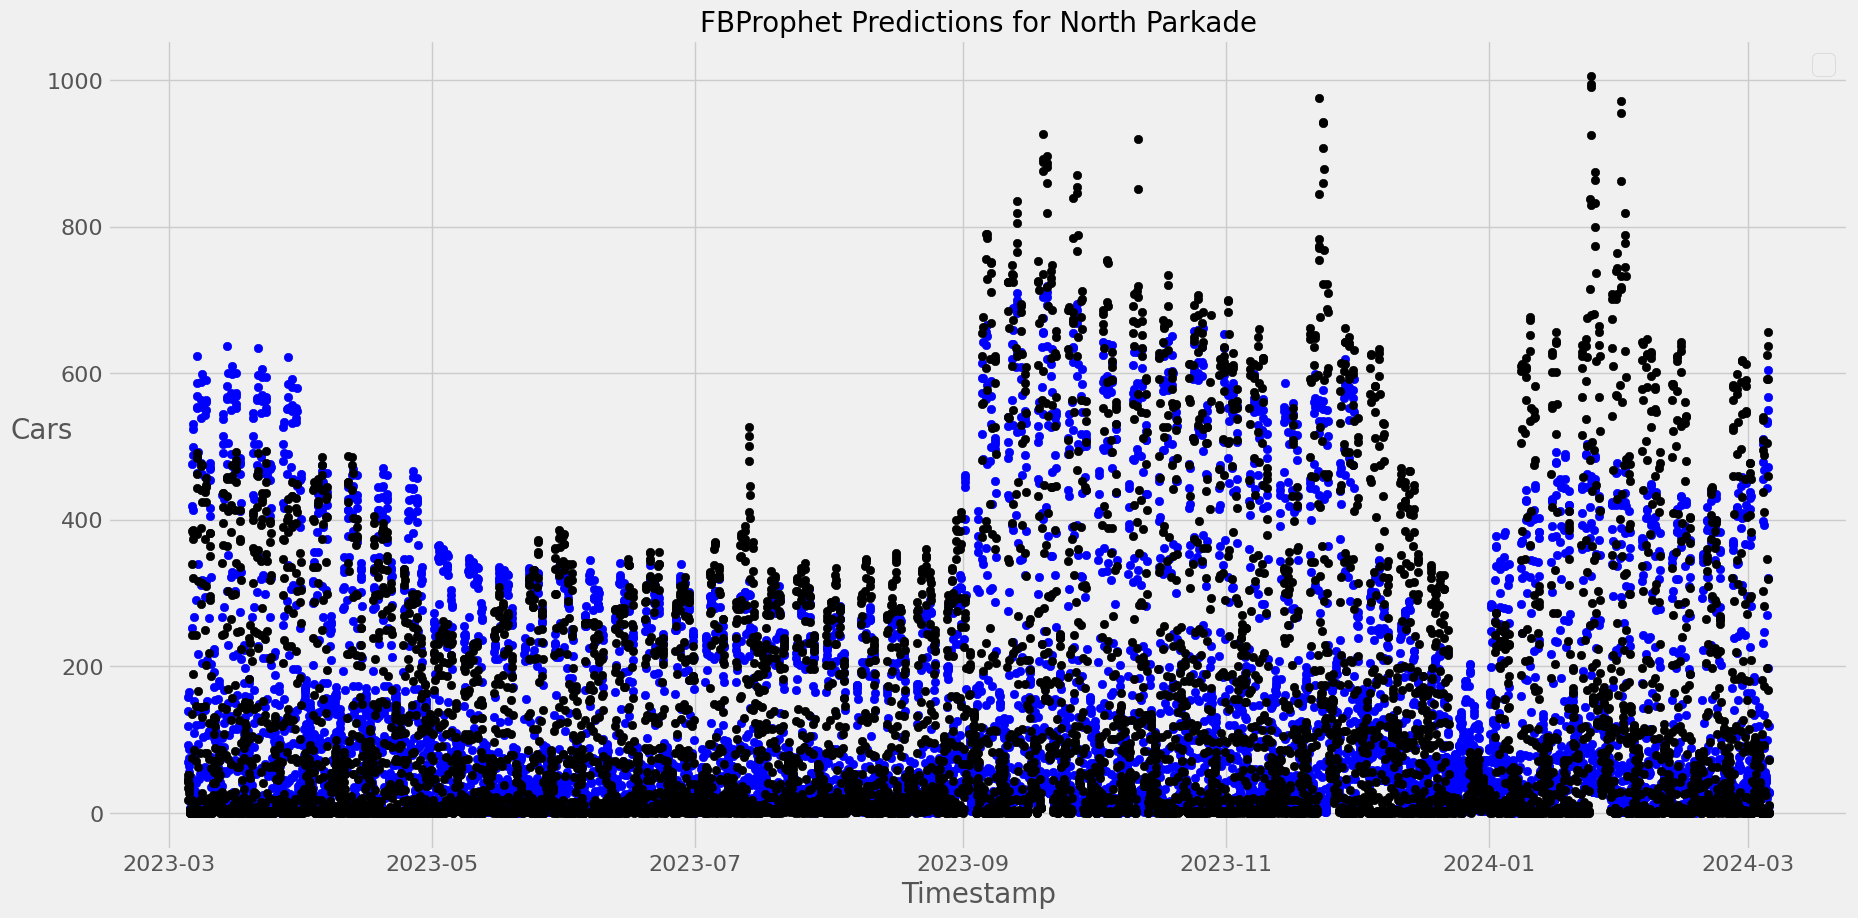

In [14]:
import matplotlib.pyplot as plt
fs = 20
# Assuming 'column1' is the index and 'column2' is another column
plt.figure(figsize=(20,10))
plt.scatter(list(test_prophet["ds"]), list(np.absolute(predictions["yhat"])), color="blue")
plt.scatter(list(test_prophet["ds"]), list(test_prophet["y"]), color="black" )
# Add labels and title
plt.xlabel('Timestamp',fontsize=fs)
plt.ylabel("Cars",fontsize=fs, rotation=0)
plt.title(f'FBProphet Predictions for {parkade} Parkade',fontsize=fs)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize=fs)

# save_path = f'model_plots/baseline_{lot}.png'
# plt.savefig(save_path)

# Show the plot
# plt.show()
# save_path = f'./fbprophet_{parkade}_abs.png'
# plt.savefig(save_path)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


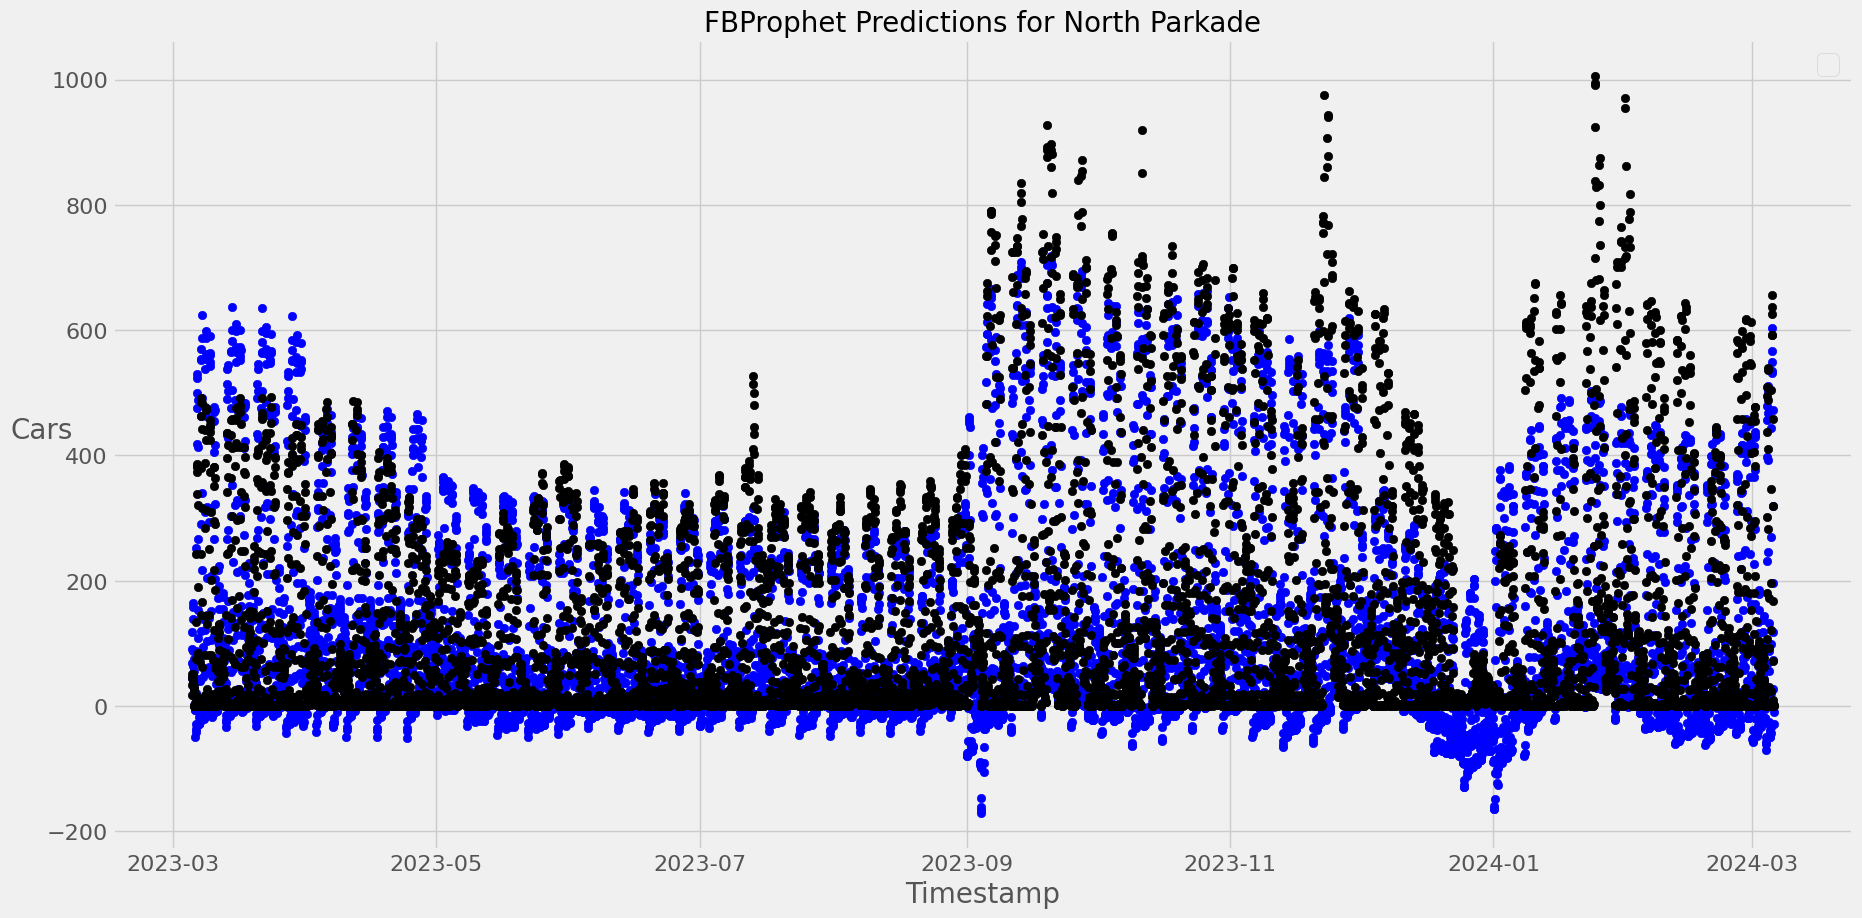

In [15]:
import matplotlib.pyplot as plt
fs = 20
# Assuming 'column1' is the index and 'column2' is another column
plt.figure(figsize=(20,10))
plt.scatter(list(test_prophet["ds"]), list((predictions["yhat"])), color="blue")
plt.scatter(list(test_prophet["ds"]), list(test_prophet["y"]), color="black" )
# Add labels and title
plt.xlabel('Timestamp',fontsize=fs)
plt.ylabel("Cars",fontsize=fs, rotation=0)
plt.title(f'FBProphet Predictions for {parkade} Parkade',fontsize=fs)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize=fs)

# save_path = f'model_plots/baseline_{lot}.png'
# plt.savefig(save_path)

# Show the plot
# plt.show()
# save_path = f'./fbprophet_{parkade}.png'
# plt.savefig(save_path)



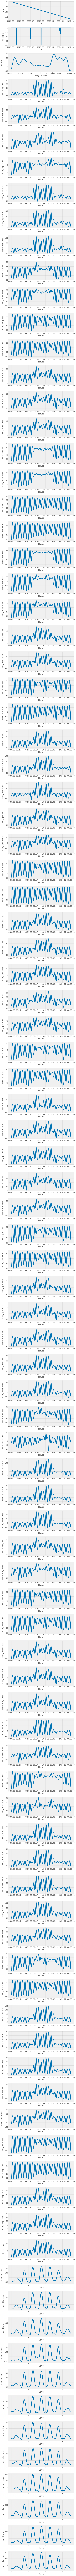

In [16]:
fig = model.plot_components(predictions)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


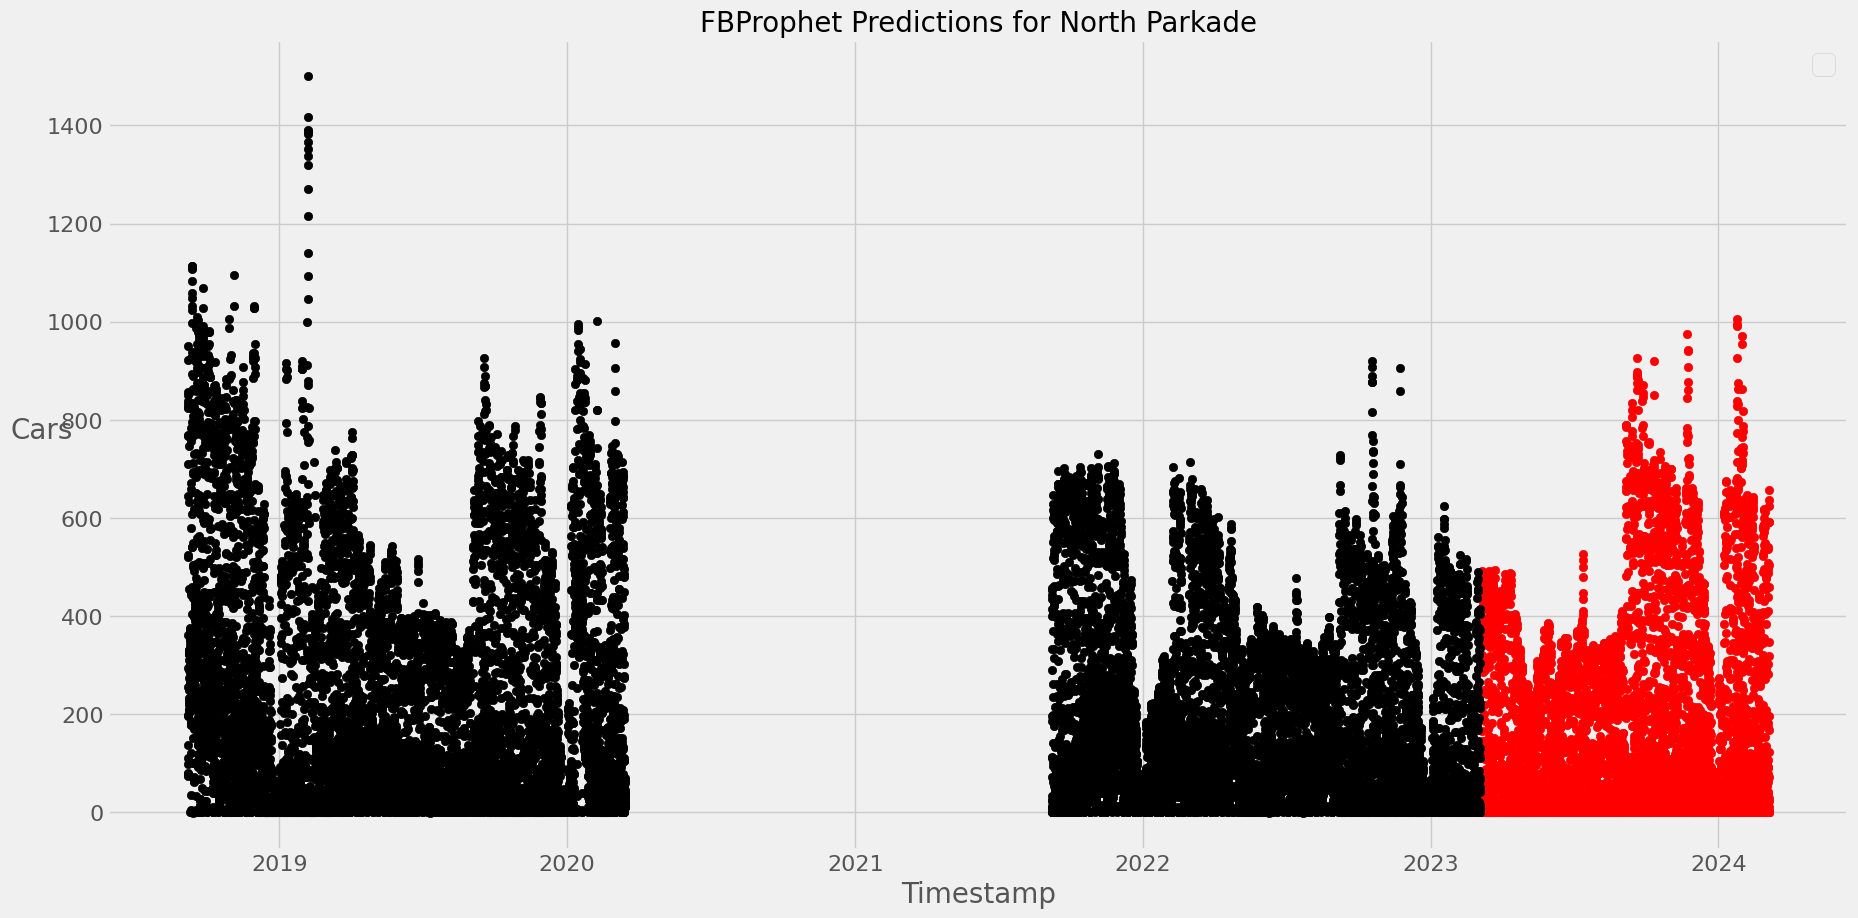

In [17]:
import matplotlib.pyplot as plt
fs = 20
# Assuming 'column1' is the index and 'column2' is another column
plt.figure(figsize=(20,10))
# plt.scatter(list(test_prophet["ds"]), list(np.absolute(predictions_list[0]["yhat"])), color="blue")
plt.scatter(list(test_prophet["ds"]), list(test_prophet["y"]), color="red" )
plt.scatter(list(train_prophet["ds"]), list(train_prophet["y"]), color="black" )

# Add labels and title
plt.xlabel('Timestamp',fontsize=fs)
plt.ylabel("Cars",fontsize=fs, rotation=0)
plt.title(f'FBProphet Predictions for {parkade} Parkade',fontsize=fs)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize=fs)

# save_path = f'model_plots/baseline_{lot}.png'
# plt.savefig(save_path)

# Show the plot
# plt.show()


In [18]:
# 06:56:08 - cmdstanpy - INFO - Chain [1] start processing
# 06:57:30 - cmdstanpy - INFO - Chain [1] done processing
#               West
# metrics           
# MAE        61.7043
# MSE      9689.9318
# RMSE       98.4375
# R2          0.8149
# --------------
#                West
# metrics            
# MAE_abs     58.1032
# MSE_abs   9359.7885
# RMSE_abs    96.7460
# R2_abs       0.8212
# ----------------------------------------------------------